In [116]:
from imports_func import *
from dbase import *

In [117]:
X=np.load('/home/miquel/ForMiquel/CLEAN2/X_c1_1j_full2.npy') 
#X2=np.load('/home/miquel/ForMiquel/CLEAN2/X_c2_1j.npy')
#X3=np.load('/home/miquel/ForMiquel/CLEAN2/X_c3_1j.npy')
#X=np.concatenate((X1, X2), axis=1)
#X=np.concatenate((X, X3), axis=1)
y=np.load('/home/miquel/ForMiquel/CLEAN2/y_1j_full2.npy') #subject labels
sub_id=np.load('/home/miquel/ForMiquel/CLEAN2/sub_id_short.npy') #subject idxs
jac_idx=np.load('/home/miquel/ForMiquel/CLEAN2/jac_idx_1j_full2.npy')

In [118]:
# build vector with dt's
dt=[]
for i in range(0,len(sub_id)):
    dt.append(Subjects[sub_id[i]].jacobians[jac_idx[i]].dt)

dt = np.asarray(dt)/365 
#dt=np.reshape(dt, (124,1))

In [108]:
def KFold_AUC(X, y, folds, percentage, dt):
    #returns AUCavg of KFold
    l2=X.shape[0]
    AUC_l = []
    fold = 1
    kf = cross_validation.KFold(l2, n_folds=folds)
    for train_index, test_index in kf: 
        X_train = X[train_index,:]
        X_test = X[test_index,:]
        y_train = y[train_index]
        y_test = y[test_index]
        dt_test = dt[test_index]
        
        print("fold:", fold)
        fold = fold + 1
        
        S = SelectPercentile(percentile=percentage)
        S.fit(X_train, y_train)
        X_train = X_train[:,S.get_support()]
        X_test = X_test[:,S.get_support()]
        
        print("shape X:", np.shape(X_train))
        
        clf = LogisticRegression(solver='liblinear', penalty='l2',class_weight='balanced', C=0.01)
        clf.fit(X_train, y_train)
        probas_ = clf.predict_proba(X_test)
        
        mask0 = np.where(dt_test>1.09)#~400 days
        mask0 = np.asarray(mask0)
        probas_ = probas_[:, 1]
        probas_ = probas_[mask0][0]
        y_test = y_test[mask0][0]
        
        fpr, tpr, thresholds = roc_curve(y_test, probas_)
        roc_auc = sklearn.metrics.auc(fpr, tpr)
        AUC_l.append(roc_auc)
    
    AUC = np.mean(AUC_l)
    print(AUC_l)
    
    return AUC


In [112]:
def AUC_percentages(X, y, linspace, folds, dt):
    #calls KFold_AUC for different percentages indicated by linspace and returns the best performance (AUCavg max)
    AUC_l = []
    
    for percentage in linspace:
        print("percentage:", percentage)
        AUC = KFold_AUC(X, y, folds, percentage, dt)
        AUC_l.append(AUC)
        
        
    maxi = np.amax(AUC_l)
    maxi_idx = np.argmax(AUC_l)
    
    return maxi, maxi_idx
        


In [113]:
def AUC_nested_CV(X, y, linspace, splits, folds, dt):
    #takes maximum of AUC_percentages for each split and calculates its corresponding AUC and roc_curve
    
    percentages_l = [] #optimal percentage for each split
    AUCmax_l = [] #AUCmax corresponding to optimal percentage in train
    AUC_g = [] #AUC of each split
    
    spl = StratifiedShuffleSplit(n_splits=splits, test_size=0.3, random_state=41)
    split=1
    
    for train_index, test_index in spl.split(X, y):
        X_train = X[train_index,:]
        y_train = y[train_index]
        X_test = X[test_index,:]
        y_test = y[test_index]
        dt_test = dt[test_index]
        dt_train = dt[train_index]
        print("split:", split)
        split = split + 1
        
        maxi, maxi_idx = AUC_percentages(X_train, y_train, linspace, folds, dt)
        percentages_l.append(linspace[maxi_idx])
        AUCmax_l.append(maxi)
        
        S = SelectPercentile(percentile=linspace[maxi_idx])
        S.fit(X_train, y_train)
        
        X_train_s = X_train[:,S.get_support()]
        X_test_s = X_test[:,S.get_support()]
        
        clf = LogisticRegression(solver='liblinear', penalty='l2',class_weight='balanced', C=0.01)
        clf.fit(X_train_s, y_train)
        
        probas_ = clf.predict_proba(X_test_s)
        
        mask0 = np.where(dt_test>1.09)#~400 days
        mask0 = np.asarray(mask0)
        probas_ = probas_[:, 1]
        probas_ = probas_[mask0][0]
        y_test = y_test[mask0][0]
        
        fpr, tpr, thresholds = roc_curve(y_test, probas_)
        roc_auc = sklearn.metrics.auc(fpr, tpr)
        AUC_g.append(roc_auc)
        
        plt.figure()
        plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
        plt.xlim([-0.05, 1.05])
        plt.ylim([-0.05, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic')
        plt.legend(loc="lower right")
        plt.show()
        
    print("AUCmax_list:", AUCmax_l)
    print("AUC splits:", AUC_g)
    print("mean AUC splits:", np.mean(AUC_g))
        
        
    

split: 1
percentage: 0.1
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     71     80 ..., 572735 572736 572737] are constant.
  UserWarning)
/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


shape X: (43, 573)
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     72 ..., 572733 572736 572737] are constant.
  UserWarning)


shape X: (43, 573)
[0.62857142857142856, 0.35714285714285715]
percentage: 0.204545454545
fold: 1
shape X: (43, 1172)
fold: 2
shape X: (43, 1172)
[0.65714285714285714, 0.3571428571428571]
percentage: 0.309090909091
fold: 1
shape X: (43, 1771)
fold: 2
shape X: (43, 1771)
[0.54285714285714293, 0.3571428571428571]
percentage: 0.413636363636
fold: 1
shape X: (43, 2370)
fold: 2
shape X: (43, 2370)
[0.54285714285714293, 0.34920634920634919]
percentage: 0.518181818182
fold: 1
shape X: (43, 2968)
fold: 2
shape X: (43, 2968)
[0.54285714285714293, 0.34126984126984128]
percentage: 0.622727272727
fold: 1
shape X: (43, 3567)
fold: 2
shape X: (43, 3567)
[0.54285714285714293, 0.33333333333333331]
percentage: 0.727272727273
fold: 1
shape X: (43, 4166)
fold: 2
shape X: (43, 4166)
[0.54285714285714293, 0.33333333333333331]
percentage: 0.831818181818
fold: 1
shape X: (43, 4765)
fold: 2
shape X: (43, 4765)
[0.54285714285714293, 0.31746031746031744]
percentage: 0.936363636364
fold: 1
shape X: (43, 5363)
fol

/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    149 ..., 572733 572736 572737] are constant.
  UserWarning)


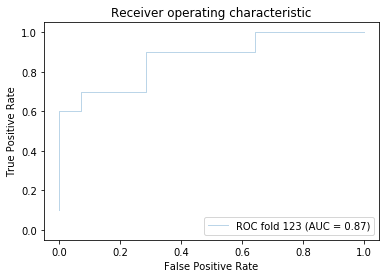

split: 2
percentage: 0.1
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     80 ..., 572735 572736 572737] are constant.
  UserWarning)


shape X: (43, 573)
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     71 ..., 572731 572732 572735] are constant.
  UserWarning)


shape X: (43, 573)
[0.65625, 0.67333333333333323]
percentage: 0.204545454545
fold: 1
shape X: (43, 1172)
fold: 2
shape X: (43, 1172)
[0.65625, 0.6333333333333333]
percentage: 0.309090909091
fold: 1
shape X: (43, 1771)
fold: 2
shape X: (43, 1771)
[0.625, 0.6333333333333333]
percentage: 0.413636363636
fold: 1
shape X: (43, 2370)
fold: 2
shape X: (43, 2370)
[0.65625, 0.6333333333333333]
percentage: 0.518181818182
fold: 1
shape X: (43, 2968)
fold: 2
shape X: (43, 2968)
[0.65625, 0.62666666666666671]
percentage: 0.622727272727
fold: 1
shape X: (43, 3567)
fold: 2
shape X: (43, 3567)
[0.65625, 0.62666666666666671]
percentage: 0.727272727273
fold: 1
shape X: (43, 4166)
fold: 2
shape X: (43, 4166)
[0.65625, 0.62666666666666671]
percentage: 0.831818181818
fold: 1
shape X: (43, 4765)
fold: 2
shape X: (43, 4765)
[0.65625, 0.64000000000000012]
percentage: 0.936363636364
fold: 1
shape X: (43, 5363)
fold: 2
shape X: (43, 5363)
[0.625, 0.63333333333333341]
percentage: 1.04090909091
fold: 1
shape X: (4

/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     80 ..., 572731 572732 572735] are constant.
  UserWarning)


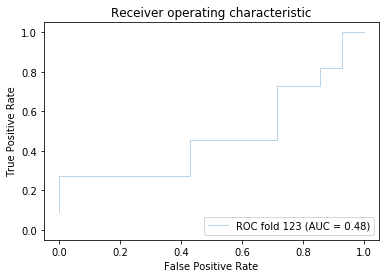

split: 3
percentage: 0.1
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     71 ..., 572733 572736 572737] are constant.
  UserWarning)


shape X: (43, 573)
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     85 ..., 572731 572732 572735] are constant.
  UserWarning)


shape X: (43, 573)
[0.4285714285714286, 0.34027777777777779]
percentage: 0.204545454545
fold: 1
shape X: (43, 1172)
fold: 2
shape X: (43, 1172)
[0.45714285714285713, 0.34722222222222221]
percentage: 0.309090909091
fold: 1
shape X: (43, 1771)
fold: 2
shape X: (43, 1771)
[0.45714285714285713, 0.34722222222222221]
percentage: 0.413636363636
fold: 1
shape X: (43, 2370)
fold: 2
shape X: (43, 2370)
[0.48571428571428571, 0.36805555555555552]
percentage: 0.518181818182
fold: 1
shape X: (43, 2968)
fold: 2
shape X: (43, 2968)
[0.51428571428571423, 0.36111111111111105]
percentage: 0.622727272727
fold: 1
shape X: (43, 3567)
fold: 2
shape X: (43, 3567)
[0.51428571428571423, 0.38194444444444442]
percentage: 0.727272727273
fold: 1
shape X: (43, 4166)
fold: 2
shape X: (43, 4166)
[0.51428571428571423, 0.38888888888888884]
percentage: 0.831818181818
fold: 1
shape X: (43, 4765)
fold: 2
shape X: (43, 4765)
[0.51428571428571423, 0.4236111111111111]
percentage: 0.936363636364
fold: 1
shape X: (43, 5363)
fol

/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     90     99 ..., 572728 572729 572730] are constant.
  UserWarning)


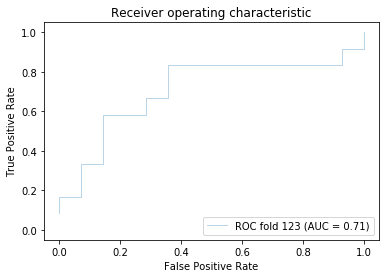

split: 4
percentage: 0.1
fold: 1
shape X: (43, 573)
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     85 ..., 572735 572736 572737] are constant.
  UserWarning)


shape X: (43, 573)
[0.63888888888888884, 0.63333333333333341]
percentage: 0.204545454545
fold: 1
shape X: (43, 1172)
fold: 2
shape X: (43, 1172)
[0.66666666666666674, 0.62000000000000011]
percentage: 0.309090909091
fold: 1
shape X: (43, 1771)
fold: 2
shape X: (43, 1771)
[0.66666666666666674, 0.62666666666666659]
percentage: 0.413636363636
fold: 1
shape X: (43, 2370)
fold: 2
shape X: (43, 2370)
[0.69444444444444442, 0.6333333333333333]
percentage: 0.518181818182
fold: 1
shape X: (43, 2968)
fold: 2
shape X: (43, 2968)
[0.69444444444444442, 0.64000000000000001]
percentage: 0.622727272727
fold: 1
shape X: (43, 3567)
fold: 2
shape X: (43, 3567)
[0.69444444444444442, 0.6333333333333333]
percentage: 0.727272727273
fold: 1
shape X: (43, 4166)
fold: 2
shape X: (43, 4166)
[0.69444444444444442, 0.64666666666666672]
percentage: 0.831818181818
fold: 1
shape X: (43, 4765)
fold: 2
shape X: (43, 4765)
[0.69444444444444442, 0.64666666666666672]
percentage: 0.936363636364
fold: 1
shape X: (43, 5363)
fol

/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    274 ..., 572733 572736 572737] are constant.
  UserWarning)


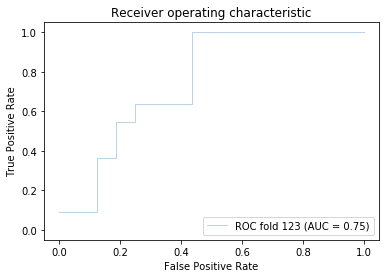

split: 5
percentage: 0.1
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     90 ..., 572733 572736 572737] are constant.
  UserWarning)


shape X: (43, 573)
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     84 ..., 572735 572736 572737] are constant.
  UserWarning)


shape X: (43, 573)
[0.63888888888888884, 0.51948051948051943]
percentage: 0.204545454545
fold: 1
shape X: (43, 1172)
fold: 2
shape X: (43, 1172)
[0.63888888888888884, 0.55194805194805197]
percentage: 0.309090909091
fold: 1
shape X: (43, 1771)
fold: 2
shape X: (43, 1771)
[0.66666666666666674, 0.54545454545454541]
percentage: 0.413636363636
fold: 1
shape X: (43, 2370)
fold: 2
shape X: (43, 2370)
[0.66666666666666674, 0.55844155844155841]
percentage: 0.518181818182
fold: 1
shape X: (43, 2968)
fold: 2
shape X: (43, 2968)
[0.66666666666666674, 0.55194805194805197]
percentage: 0.622727272727
fold: 1
shape X: (43, 3567)
fold: 2
shape X: (43, 3567)
[0.63888888888888895, 0.55844155844155841]
percentage: 0.727272727273
fold: 1
shape X: (43, 4166)
fold: 2
shape X: (43, 4166)
[0.66666666666666674, 0.55844155844155841]
percentage: 0.831818181818
fold: 1
shape X: (43, 4765)
fold: 2
shape X: (43, 4765)
[0.66666666666666674, 0.55194805194805197]
percentage: 0.936363636364
fold: 1
shape X: (43, 5363)
f

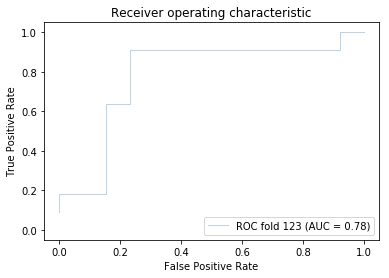

split: 6
percentage: 0.1
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     72     80 ..., 572731 572732 572735] are constant.
  UserWarning)


shape X: (43, 573)
fold: 2
shape X: (43, 573)
[0.375, 0.59558823529411764]
percentage: 0.204545454545
fold: 1
shape X: (43, 1172)
fold: 2
shape X: (43, 1172)
[0.40625, 0.60294117647058831]
percentage: 0.309090909091
fold: 1
shape X: (43, 1771)
fold: 2
shape X: (43, 1771)
[0.40625, 0.60294117647058831]
percentage: 0.413636363636
fold: 1
shape X: (43, 2370)
fold: 2
shape X: (43, 2370)
[0.40625, 0.61029411764705888]
percentage: 0.518181818182
fold: 1
shape X: (43, 2968)
fold: 2
shape X: (43, 2968)
[0.40625, 0.61764705882352944]
percentage: 0.622727272727
fold: 1
shape X: (43, 3567)
fold: 2
shape X: (43, 3567)
[0.40625, 0.625]
percentage: 0.727272727273
fold: 1
shape X: (43, 4166)
fold: 2
shape X: (43, 4166)
[0.40625, 0.63235294117647056]
percentage: 0.831818181818
fold: 1
shape X: (43, 4765)
fold: 2
shape X: (43, 4765)
[0.40625, 0.63970588235294112]
percentage: 0.936363636364
fold: 1
shape X: (43, 5363)
fold: 2
shape X: (43, 5363)
[0.4375, 0.63970588235294112]
percentage: 1.04090909091
fo

/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    178 ..., 572703 572708 572709] are constant.
  UserWarning)


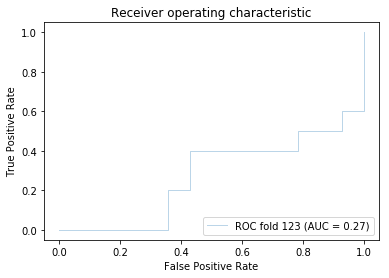

split: 7
percentage: 0.1
fold: 1
shape X: (43, 573)
fold: 2
shape X: (43, 573)
[0.54285714285714293, 0.47916666666666669]
percentage: 0.204545454545
fold: 1
shape X: (43, 1172)
fold: 2
shape X: (43, 1172)
[0.51428571428571423, 0.50694444444444442]
percentage: 0.309090909091
fold: 1
shape X: (43, 1771)
fold: 2
shape X: (43, 1771)
[0.54285714285714282, 0.51388888888888884]
percentage: 0.413636363636
fold: 1
shape X: (43, 2370)
fold: 2
shape X: (43, 2370)
[0.54285714285714282, 0.51388888888888884]
percentage: 0.518181818182
fold: 1
shape X: (43, 2968)
fold: 2
shape X: (43, 2968)
[0.54285714285714282, 0.51388888888888884]
percentage: 0.622727272727
fold: 1
shape X: (43, 3567)
fold: 2
shape X: (43, 3567)
[0.54285714285714282, 0.51388888888888884]
percentage: 0.727272727273
fold: 1
shape X: (43, 4166)
fold: 2
shape X: (43, 4166)
[0.54285714285714282, 0.50694444444444442]
percentage: 0.831818181818
fold: 1
shape X: (43, 4765)
fold: 2
shape X: (43, 4765)
[0.54285714285714282, 0.506944444444444

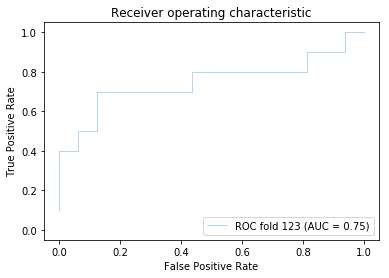

split: 8
percentage: 0.1
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     72     80 ..., 572733 572736 572737] are constant.
  UserWarning)


shape X: (43, 573)
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     90 ..., 572735 572736 572737] are constant.
  UserWarning)


shape X: (43, 573)
[0.54285714285714282, 0.40000000000000002]
percentage: 0.204545454545
fold: 1
shape X: (43, 1172)
fold: 2
shape X: (43, 1172)
[0.59999999999999998, 0.42666666666666664]
percentage: 0.309090909091
fold: 1
shape X: (43, 1771)
fold: 2
shape X: (43, 1771)
[0.62857142857142856, 0.42666666666666664]
percentage: 0.413636363636
fold: 1
shape X: (43, 2370)
fold: 2
shape X: (43, 2370)
[0.62857142857142856, 0.43333333333333335]
percentage: 0.518181818182
fold: 1
shape X: (43, 2968)
fold: 2
shape X: (43, 2968)
[0.5714285714285714, 0.42666666666666664]
percentage: 0.622727272727
fold: 1
shape X: (43, 3567)
fold: 2
shape X: (43, 3567)
[0.5714285714285714, 0.42666666666666664]
percentage: 0.727272727273
fold: 1
shape X: (43, 4166)
fold: 2
shape X: (43, 4166)
[0.5714285714285714, 0.43333333333333335]
percentage: 0.831818181818
fold: 1
shape X: (43, 4765)
fold: 2
shape X: (43, 4765)
[0.5714285714285714, 0.42666666666666664]
percentage: 0.936363636364
fold: 1
shape X: (43, 5363)
fold:

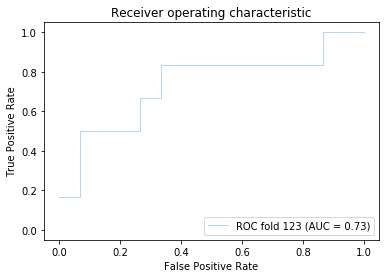

split: 9
percentage: 0.1
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     72     99 ..., 572735 572736 572737] are constant.
  UserWarning)


shape X: (43, 573)
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     80 ..., 572733 572736 572737] are constant.
  UserWarning)


shape X: (43, 573)
[0.55000000000000004, 0.61029411764705876]
percentage: 0.204545454545
fold: 1
shape X: (43, 1172)
fold: 2
shape X: (43, 1172)
[0.55000000000000004, 0.58088235294117641]
percentage: 0.309090909091
fold: 1
shape X: (43, 1771)
fold: 2
shape X: (43, 1771)
[0.55000000000000004, 0.53676470588235292]
percentage: 0.413636363636
fold: 1
shape X: (43, 2370)
fold: 2
shape X: (43, 2370)
[0.55000000000000004, 0.50735294117647056]
percentage: 0.518181818182
fold: 1
shape X: (43, 2968)
fold: 2
shape X: (43, 2968)
[0.55000000000000004, 0.50735294117647056]
percentage: 0.622727272727
fold: 1
shape X: (43, 3567)
fold: 2
shape X: (43, 3567)
[0.55000000000000004, 0.47794117647058826]
percentage: 0.727272727273
fold: 1
shape X: (43, 4166)
fold: 2
shape X: (43, 4166)
[0.55000000000000004, 0.48529411764705882]
percentage: 0.831818181818
fold: 1
shape X: (43, 4765)
fold: 2
shape X: (43, 4765)
[0.55000000000000004, 0.49264705882352944]
percentage: 0.936363636364
fold: 1
shape X: (43, 5363)
f

/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    178 ..., 572733 572736 572737] are constant.
  UserWarning)


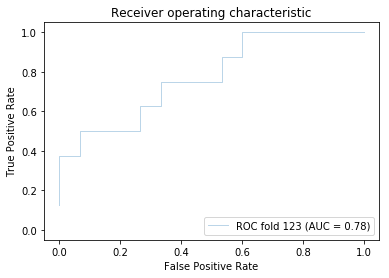

split: 10
percentage: 0.1
fold: 1


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     83 ..., 572720 572721 572722] are constant.
  UserWarning)


shape X: (43, 573)
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     72 ..., 572735 572736 572737] are constant.
  UserWarning)


shape X: (43, 573)
[0.27777777777777773, 0.41333333333333333]
percentage: 0.204545454545
fold: 1
shape X: (43, 1172)
fold: 2
shape X: (43, 1172)
[0.25, 0.44666666666666666]
percentage: 0.309090909091
fold: 1
shape X: (43, 1771)
fold: 2
shape X: (43, 1771)
[0.27777777777777785, 0.45333333333333337]
percentage: 0.413636363636
fold: 1
shape X: (43, 2370)
fold: 2
shape X: (43, 2370)
[0.3611111111111111, 0.45333333333333337]
percentage: 0.518181818182
fold: 1
shape X: (43, 2968)
fold: 2
shape X: (43, 2968)
[0.3611111111111111, 0.46000000000000002]
percentage: 0.622727272727
fold: 1
shape X: (43, 3567)
fold: 2
shape X: (43, 3567)
[0.3611111111111111, 0.45333333333333337]
percentage: 0.727272727273
fold: 1
shape X: (43, 4166)
fold: 2
shape X: (43, 4166)
[0.3611111111111111, 0.46000000000000002]
percentage: 0.831818181818
fold: 1
shape X: (43, 4765)
fold: 2
shape X: (43, 4765)
[0.30555555555555558, 0.44666666666666666]
percentage: 0.936363636364
fold: 1
shape X: (43, 5363)
fold: 2
shape X: (43

/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    274 ..., 572720 572721 572722] are constant.
  UserWarning)


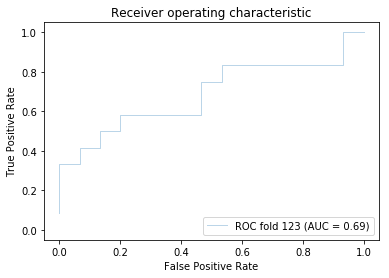

split: 11
percentage: 0.1
fold: 1
shape X: (43, 573)
fold: 2
shape X: (43, 573)
[1.0, 0.88961038961038952]
percentage: 0.204545454545
fold: 1
shape X: (43, 1172)
fold: 2
shape X: (43, 1172)
[1.0, 0.89610389610389607]
percentage: 0.309090909091
fold: 1
shape X: (43, 1771)
fold: 2
shape X: (43, 1771)
[1.0, 0.88961038961038952]
percentage: 0.413636363636
fold: 1
shape X: (43, 2370)
fold: 2
shape X: (43, 2370)
[1.0, 0.88961038961038952]
percentage: 0.518181818182
fold: 1
shape X: (43, 2968)
fold: 2
shape X: (43, 2968)
[1.0, 0.88961038961038952]
percentage: 0.622727272727
fold: 1
shape X: (43, 3567)
fold: 2
shape X: (43, 3567)
[1.0, 0.88961038961038952]
percentage: 0.727272727273
fold: 1
shape X: (43, 4166)
fold: 2
shape X: (43, 4166)
[1.0, 0.88961038961038952]
percentage: 0.831818181818
fold: 1
shape X: (43, 4765)
fold: 2
shape X: (43, 4765)
[1.0, 0.87662337662337664]
percentage: 0.936363636364
fold: 1
shape X: (43, 5363)
fold: 2
shape X: (43, 5363)
[1.0, 0.88311688311688297]
percentage: 1

/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     90     99 ..., 572733 572736 572737] are constant.
  UserWarning)


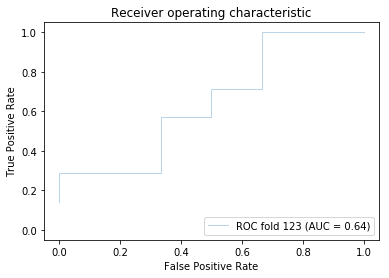

split: 12
percentage: 0.1
fold: 1
shape X: (43, 573)
fold: 2
shape X: (43, 573)
[0.71428571428571419, 0.34000000000000002]
percentage: 0.204545454545
fold: 1
shape X: (43, 1172)
fold: 2
shape X: (43, 1172)
[0.71428571428571419, 0.34666666666666673]
percentage: 0.309090909091
fold: 1
shape X: (43, 1771)
fold: 2
shape X: (43, 1771)
[0.77142857142857146, 0.34666666666666668]
percentage: 0.413636363636
fold: 1
shape X: (43, 2370)
fold: 2
shape X: (43, 2370)
[0.80000000000000004, 0.34666666666666668]
percentage: 0.518181818182
fold: 1
shape X: (43, 2968)
fold: 2
shape X: (43, 2968)
[0.80000000000000004, 0.35333333333333333]
percentage: 0.622727272727
fold: 1
shape X: (43, 3567)
fold: 2
shape X: (43, 3567)
[0.80000000000000004, 0.34000000000000002]
percentage: 0.727272727273
fold: 1
shape X: (43, 4166)
fold: 2
shape X: (43, 4166)
[0.80000000000000004, 0.36000000000000004]
percentage: 0.831818181818
fold: 1
shape X: (43, 4765)
fold: 2
shape X: (43, 4765)
[0.80000000000000004, 0.36666666666666

/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     84 ..., 572731 572732 572735] are constant.
  UserWarning)


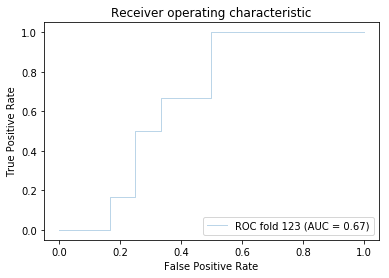

split: 13
percentage: 0.1
fold: 1
shape X: (43, 573)
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     80     85 ..., 572728 572729 572730] are constant.
  UserWarning)


shape X: (43, 573)
[0.51428571428571435, 0.69444444444444442]
percentage: 0.204545454545
fold: 1
shape X: (43, 1172)
fold: 2
shape X: (43, 1172)
[0.45714285714285713, 0.65277777777777779]
percentage: 0.309090909091
fold: 1
shape X: (43, 1771)
fold: 2
shape X: (43, 1771)
[0.48571428571428577, 0.65277777777777779]
percentage: 0.413636363636
fold: 1
shape X: (43, 2370)
fold: 2
shape X: (43, 2370)
[0.45714285714285713, 0.64583333333333326]
percentage: 0.518181818182
fold: 1
shape X: (43, 2968)
fold: 2
shape X: (43, 2968)
[0.4285714285714286, 0.64583333333333337]
percentage: 0.622727272727
fold: 1
shape X: (43, 3567)
fold: 2
shape X: (43, 3567)
[0.45714285714285718, 0.64583333333333337]
percentage: 0.727272727273
fold: 1
shape X: (43, 4166)
fold: 2
shape X: (43, 4166)
[0.4285714285714286, 0.65277777777777779]
percentage: 0.831818181818
fold: 1
shape X: (43, 4765)
fold: 2
shape X: (43, 4765)
[0.45714285714285713, 0.65972222222222221]
percentage: 0.936363636364
fold: 1
shape X: (43, 5363)
fol

/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    178 ..., 572720 572721 572722] are constant.
  UserWarning)


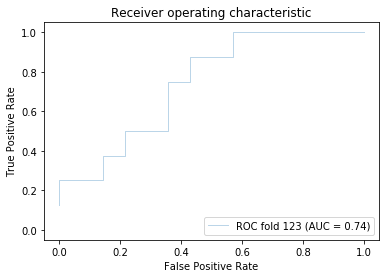

split: 14
percentage: 0.1
fold: 1
shape X: (43, 573)
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     5     13     80 ..., 572731 572732 572735] are constant.
  UserWarning)


shape X: (43, 573)
[0.5625, 0.51282051282051277]
percentage: 0.204545454545
fold: 1
shape X: (43, 1172)
fold: 2
shape X: (43, 1172)
[0.5625, 0.50641025641025639]
percentage: 0.309090909091
fold: 1
shape X: (43, 1771)
fold: 2
shape X: (43, 1771)
[0.59375, 0.51282051282051277]
percentage: 0.413636363636
fold: 1
shape X: (43, 2370)
fold: 2
shape X: (43, 2370)
[0.59375, 0.51282051282051277]
percentage: 0.518181818182
fold: 1
shape X: (43, 2968)
fold: 2
shape X: (43, 2968)
[0.5625, 0.51923076923076927]
percentage: 0.622727272727
fold: 1
shape X: (43, 3567)
fold: 2
shape X: (43, 3567)
[0.5625, 0.51282051282051277]
percentage: 0.727272727273
fold: 1
shape X: (43, 4166)
fold: 2
shape X: (43, 4166)
[0.5625, 0.51282051282051277]
percentage: 0.831818181818
fold: 1
shape X: (43, 4765)
fold: 2
shape X: (43, 4765)
[0.5625, 0.51923076923076927]
percentage: 0.936363636364
fold: 1
shape X: (43, 5363)
fold: 2
shape X: (43, 5363)
[0.59375, 0.50641025641025639]
percentage: 1.04090909091
fold: 1
shape X: (

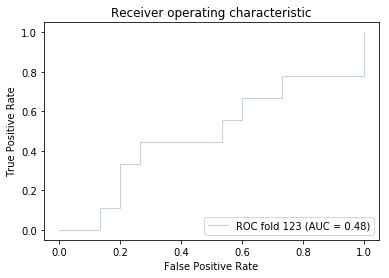

split: 15
percentage: 0.1
fold: 1
shape X: (43, 573)
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     72     90 ..., 572712 572713 572714] are constant.
  UserWarning)


shape X: (43, 573)
[0.47222222222222221, 0.45138888888888884]
percentage: 0.204545454545
fold: 1
shape X: (43, 1172)
fold: 2
shape X: (43, 1172)
[0.47222222222222221, 0.45138888888888884]
percentage: 0.309090909091
fold: 1
shape X: (43, 1771)
fold: 2
shape X: (43, 1771)
[0.47222222222222221, 0.45138888888888895]
percentage: 0.413636363636
fold: 1
shape X: (43, 2370)
fold: 2
shape X: (43, 2370)
[0.47222222222222221, 0.46527777777777779]
percentage: 0.518181818182
fold: 1
shape X: (43, 2968)
fold: 2
shape X: (43, 2968)
[0.47222222222222221, 0.45833333333333337]
percentage: 0.622727272727
fold: 1
shape X: (43, 3567)
fold: 2
shape X: (43, 3567)
[0.47222222222222221, 0.45833333333333337]
percentage: 0.727272727273
fold: 1
shape X: (43, 4166)
fold: 2
shape X: (43, 4166)
[0.47222222222222221, 0.46527777777777779]
percentage: 0.831818181818
fold: 1
shape X: (43, 4765)
fold: 2
shape X: (43, 4765)
[0.47222222222222221, 0.47222222222222221]
percentage: 0.936363636364
fold: 1
shape X: (43, 5363)
f

/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    264 ..., 572692 572702 572703] are constant.
  UserWarning)


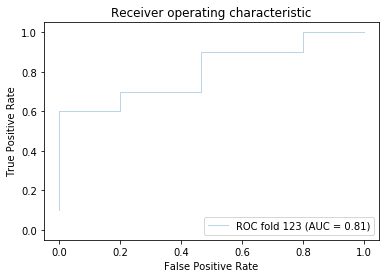

split: 16
percentage: 0.1
fold: 1
shape X: (43, 573)
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     4     13     71 ..., 572735 572736 572737] are constant.
  UserWarning)


shape X: (43, 573)
[0.37142857142857144, 0.73376623376623373]
percentage: 0.204545454545
fold: 1
shape X: (43, 1172)
fold: 2
shape X: (43, 1172)
[0.37142857142857144, 0.72727272727272729]
percentage: 0.309090909091
fold: 1
shape X: (43, 1771)
fold: 2
shape X: (43, 1771)
[0.4285714285714286, 0.74025974025974028]
percentage: 0.413636363636
fold: 1
shape X: (43, 2370)
fold: 2
shape X: (43, 2370)
[0.4285714285714286, 0.76623376623376616]
percentage: 0.518181818182
fold: 1
shape X: (43, 2968)
fold: 2
shape X: (43, 2968)
[0.4285714285714286, 0.77272727272727271]
percentage: 0.622727272727
fold: 1
shape X: (43, 3567)
fold: 2
shape X: (43, 3567)
[0.4285714285714286, 0.77922077922077926]
percentage: 0.727272727273
fold: 1
shape X: (43, 4166)
fold: 2
shape X: (43, 4166)
[0.4285714285714286, 0.7857142857142857]
percentage: 0.831818181818
fold: 1
shape X: (43, 4765)
fold: 2
shape X: (43, 4765)
[0.4285714285714286, 0.77272727272727271]
percentage: 0.936363636364
fold: 1
shape X: (43, 5363)
fold: 2


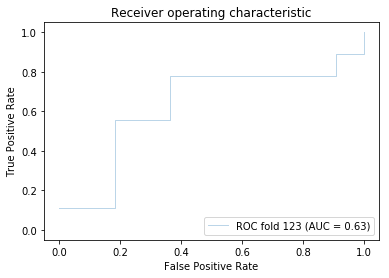

split: 17
percentage: 0.1
fold: 1
shape X: (43, 573)
fold: 2
shape X: (43, 573)
[0.59999999999999998, 0.31818181818181818]
percentage: 0.204545454545
fold: 1
shape X: (43, 1172)
fold: 2
shape X: (43, 1172)
[0.54285714285714293, 0.32467532467532467]
percentage: 0.309090909091
fold: 1
shape X: (43, 1771)
fold: 2
shape X: (43, 1771)
[0.54285714285714293, 0.31168831168831168]
percentage: 0.413636363636
fold: 1
shape X: (43, 2370)
fold: 2
shape X: (43, 2370)
[0.54285714285714293, 0.31168831168831168]
percentage: 0.518181818182
fold: 1
shape X: (43, 2968)
fold: 2
shape X: (43, 2968)
[0.51428571428571435, 0.31168831168831168]
percentage: 0.622727272727
fold: 1
shape X: (43, 3567)
fold: 2
shape X: (43, 3567)
[0.51428571428571435, 0.31168831168831168]
percentage: 0.727272727273
fold: 1
shape X: (43, 4166)
fold: 2
shape X: (43, 4166)
[0.51428571428571435, 0.30519480519480519]
percentage: 0.831818181818
fold: 1
shape X: (43, 4765)
fold: 2
shape X: (43, 4765)
[0.51428571428571435, 0.31168831168831

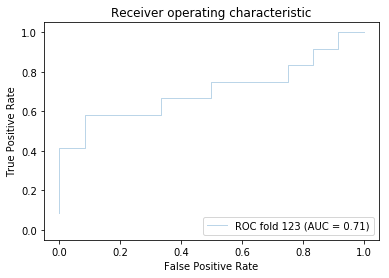

split: 18
percentage: 0.1
fold: 1
shape X: (43, 573)
fold: 2
shape X: (43, 573)
[0.54285714285714293, 0.48412698412698413]
percentage: 0.204545454545
fold: 1
shape X: (43, 1172)
fold: 2
shape X: (43, 1172)
[0.51428571428571423, 0.47619047619047622]
percentage: 0.309090909091
fold: 1
shape X: (43, 1771)
fold: 2
shape X: (43, 1771)
[0.59999999999999998, 0.46825396825396826]
percentage: 0.413636363636
fold: 1
shape X: (43, 2370)
fold: 2
shape X: (43, 2370)
[0.62857142857142856, 0.45238095238095238]
percentage: 0.518181818182
fold: 1
shape X: (43, 2968)
fold: 2
shape X: (43, 2968)
[0.62857142857142856, 0.45238095238095233]
percentage: 0.622727272727
fold: 1
shape X: (43, 3567)
fold: 2
shape X: (43, 3567)
[0.62857142857142856, 0.45238095238095233]
percentage: 0.727272727273
fold: 1
shape X: (43, 4166)
fold: 2
shape X: (43, 4166)
[0.62857142857142856, 0.47619047619047616]
percentage: 0.831818181818
fold: 1
shape X: (43, 4765)
fold: 2
shape X: (43, 4765)
[0.62857142857142856, 0.48412698412698

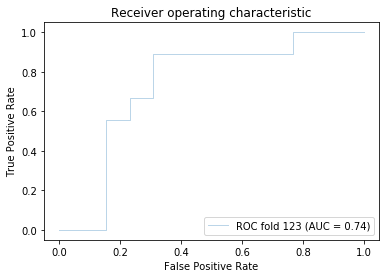

split: 19
percentage: 0.1
fold: 1
shape X: (43, 573)
fold: 2


/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     71     99 ..., 572735 572736 572737] are constant.
  UserWarning)


shape X: (43, 573)
[0.51851851851851849, 0.66883116883116878]
percentage: 0.204545454545
fold: 1
shape X: (43, 1172)
fold: 2
shape X: (43, 1172)
[0.44444444444444442, 0.6558441558441559]
percentage: 0.309090909091
fold: 1
shape X: (43, 1771)
fold: 2
shape X: (43, 1771)
[0.33333333333333337, 0.6428571428571429]
percentage: 0.413636363636
fold: 1
shape X: (43, 2370)
fold: 2
shape X: (43, 2370)
[0.33333333333333337, 0.64285714285714279]
percentage: 0.518181818182
fold: 1
shape X: (43, 2968)
fold: 2
shape X: (43, 2968)
[0.29629629629629628, 0.64935064935064934]
percentage: 0.622727272727
fold: 1
shape X: (43, 3567)
fold: 2
shape X: (43, 3567)
[0.25925925925925924, 0.6558441558441559]
percentage: 0.727272727273
fold: 1
shape X: (43, 4166)
fold: 2
shape X: (43, 4166)
[0.29629629629629628, 0.64935064935064934]
percentage: 0.831818181818
fold: 1
shape X: (43, 4765)
fold: 2
shape X: (43, 4765)
[0.25925925925925924, 0.64935064935064934]
percentage: 0.936363636364
fold: 1
shape X: (43, 5363)
fold

/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     99    149 ..., 572735 572736 572737] are constant.
  UserWarning)


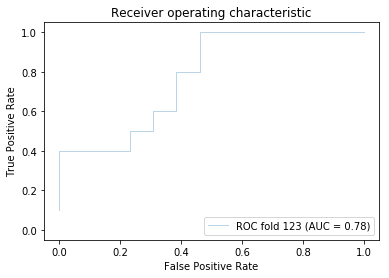

split: 20
percentage: 0.1
fold: 1
shape X: (43, 573)
fold: 2
shape X: (43, 573)
[0.5714285714285714, 0.58730158730158744]
percentage: 0.204545454545
fold: 1
shape X: (43, 1172)
fold: 2
shape X: (43, 1172)
[0.51428571428571423, 0.59523809523809523]
percentage: 0.309090909091
fold: 1
shape X: (43, 1771)
fold: 2
shape X: (43, 1771)
[0.54285714285714282, 0.59523809523809523]
percentage: 0.413636363636
fold: 1
shape X: (43, 2370)
fold: 2
shape X: (43, 2370)
[0.54285714285714282, 0.58730158730158732]
percentage: 0.518181818182
fold: 1
shape X: (43, 2968)
fold: 2
shape X: (43, 2968)
[0.51428571428571423, 0.58730158730158732]
percentage: 0.622727272727
fold: 1
shape X: (43, 3567)
fold: 2
shape X: (43, 3567)
[0.5714285714285714, 0.58730158730158732]
percentage: 0.727272727273
fold: 1
shape X: (43, 4166)
fold: 2
shape X: (43, 4166)
[0.54285714285714293, 0.58730158730158732]
percentage: 0.831818181818
fold: 1
shape X: (43, 4765)
fold: 2
shape X: (43, 4765)
[0.54285714285714293, 0.5873015873015873

/usr/local/lib/python3.4/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [    13     90     99 ..., 572735 572736 572737] are constant.
  UserWarning)


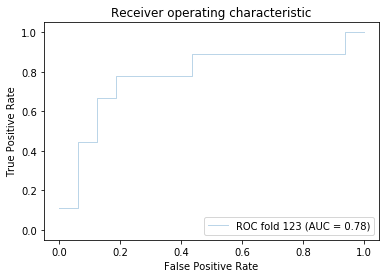

AUCmax_list: [0.50714285714285712, 0.66479166666666667, 0.50059523809523809, 0.68777777777777782, 0.6231962481962483, 0.55422794117647056, 0.52837301587301577, 0.53095238095238095, 0.58014705882352935, 0.41055555555555556, 0.94805194805194803, 0.59761904761904772, 0.60436507936507944, 0.55328525641025639, 0.47222222222222221, 0.61038961038961037, 0.45909090909090911, 0.59047619047619049, 0.59367484367484358, 0.57936507936507942]
AUC splits: [0.87142857142857144, 0.48051948051948051, 0.70833333333333326, 0.75, 0.78321678321678312, 0.27142857142857146, 0.75000000000000011, 0.73333333333333339, 0.77500000000000002, 0.68888888888888888, 0.64285714285714279, 0.66666666666666674, 0.7410714285714286, 0.48148148148148151, 0.80666666666666664, 0.62626262626262619, 0.70833333333333337, 0.73504273504273498, 0.77692307692307694, 0.77777777777777768]
mean AUC splits: 0.688761594887


In [119]:
splits = 20
folds= 2
linspace = np.linspace(0.1, 1.25, num=12)
AUC_nested_CV(X, y, linspace, splits, folds, dt)